In [ ]:
# yolov5x6 trained for 300 epochs.

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
!pip install -r requirements.txt wandb

Cloning into 'yolov5'...
remote: Enumerating objects: 12398, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 12398 (delta 56), reused 40 (delta 19), pack-reused 12293
Receiving objects: 100% (12398/12398), 12.76 MiB | 22.81 MiB/s, done.
Resolving deltas: 100% (8523/8523), done.
/content/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 12.1 MB/s 
     |████████████████████████████████| 181 kB 56.8 MB/s 
     |████████████████████████████████| 158 kB 61.0 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 157 kB 61.4 MB/s 
     |████████████████████████████████| 157 kB 53.0 MB/s 
     |████████████████████████████████| 157 kB 67.1 MB/s 
     |████████████████████████████████| 157 kB 59.5 MB/s 
     |████████████████████████████████| 157 kB 67.4 MB/s 
     |███████████

In [ ]:
from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm

import shutil
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [ ]:
%%capture
%cd ..
!gdown 1-9N7Obs67AcB-Jkucx7Ny7iaf_mKdxND
!unzip rotated.zip
%mv /content/content/* /content

In [ ]:
#@title
# dataset_path = './data'
# anns_file_path = dataset_path + '/' + 'annotations.json'

# # Read annotations
# with open(anns_file_path, 'r') as f:
#     dataset = json.loads(f.read())

# categories = dataset['categories']
# anns = dataset['annotations']
# imgs = dataset['images']
# nr_cats = len(categories)
# nr_annotations = len(anns)
# nr_images = len(imgs)

# # Load categories and super categories
# cat_names = []
# super_cat_names = []
# super_cat_ids = {}
# super_cat_last_name = ''
# nr_super_cats = 0
# for cat_it in categories:
#     cat_names.append(cat_it['name'])
#     super_cat_name = cat_it['supercategory']
#     # Adding new supercat
#     if super_cat_name != super_cat_last_name:
#         super_cat_names.append(super_cat_name)
#         super_cat_ids[super_cat_name] = nr_super_cats
#         super_cat_last_name = super_cat_name
#         nr_super_cats += 1

# print('Number of super categories:', nr_super_cats)
# print('Number of categories:', nr_cats)
# print('Number of annotations:', nr_annotations)
# print('Number of images:', nr_images)

In [ ]:
# # Read annotations
# dataset_path = './data'
# anns_file_path = dataset_path + '/' + 'annotations.json'

# with open(anns_file_path, 'r') as f:
#     dataset = json.loads(f.read())
# imgs = dataset['images']

# data_source = COCO(annotation_file=anns_file_path)

In [ ]:
!pwd

/content


In [ ]:
## train test split
'''
train: images/train
val: images/val
test: images/test
'''
import random
id_list=[i for i in range(1500)]
random.shuffle(id_list)

train_ids = id_list[:1050]
val_ids = id_list[1050:1050+300]
test_ids = id_list[1050+300:]

def move_helper(ids, desti):
  for id in ids:
    img_name = os.path.join( './yoloTACO/images', str(id)+'.jpg' )
    lbl_name = os.path.join( './yoloTACO/labels', str(id)+'.txt' )
    print(img_name)
    if os.path.isfile(img_name):
        shutil.move( img_name, 'yoloTACO/images/'+desti)
        shutil.move( lbl_name, 'yoloTACO/labels/'+desti)
    else :
        print('file does not exist', img_name)

In [ ]:
%%capture
!mkdir yoloTACO/images/train
!mkdir yoloTACO/images/val
!mkdir yoloTACO/images/test
!mkdir yoloTACO/labels/train
!mkdir yoloTACO/labels/val
!mkdir yoloTACO/labels/test
move_helper(test_ids,'test')
move_helper(train_ids,'train')
move_helper(val_ids,'val')

In [ ]:
#@title yml

with open('/content/yolov5/data/yoloTACO.yaml', mode='w') as fp:
  lines = '''path: ../yoloTACO  # dataset root dir
train: images/train  # train images (relative to 'path') 128 images
val: images/val  # val images (relative to 'path') 128 images
test: images/test # test images (optional)

# Classes
names:
  0: Aluminium foil
  1: Battery
  2: Aluminium blister pack
  3: Carded blister pack
  4: Other plastic bottle
  5: Clear plastic bottle
  6: Glass bottle
  7: Plastic bottle cap
  8: Metal bottle cap
  9: Broken glass
  10: Food Can
  11: Aerosol
  12: Drink can
  13: Toilet tube
  14: Other carton
  15: Egg carton
  16: Drink carton
  17: Corrugated carton
  18: Meal carton
  19: Pizza box
  20: Paper cup
  21: Disposable plastic cup
  22: Foam cup
  23: Glass cup
  24: Other plastic cup
  25: Food waste
  26: Glass jar
  27: Plastic lid
  28: Metal lid
  29: Other plastic
  30: Magazine paper
  31: Tissues
  32: Wrapping paper
  33: Normal paper
  34: Paper bag
  35: Plastified paper bag
  36: Plastic film
  37: Six pack rings
  38: Garbage bag
  39: Other plastic wrapper
  40: Single-use carrier bag
  41: Polypropylene bag
  42: Crisp packet
  43: Spread tub
  44: Tupperware
  45: Disposable food container
  46: Foam food container
  47: Other plastic container
  48: Plastic glooves
  49: Plastic utensils
  50: Pop tab
  51: Rope & strings
  52: Scrap metal
  53: Shoe
  54: Squeezable tube
  55: Plastic straw
  56: Paper straw
  57: Styrofoam piece
  58: Unlabeled litter
  59: Cigarette'''
  fp.writelines(lines)

In [ ]:
%cd ./yolov5
!ls

/content/yolov5
benchmarks.py	 detect.py   models	       setup.cfg       val.py
classify	 export.py   README.md	       train.py
CONTRIBUTING.md  hubconf.py  requirements.txt  tutorial.ipynb
data		 LICENSE     segment	       utils


In [ ]:
!nvidia-smi

Sun Sep 18 03:32:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# check we have albu...
!pip list -v | grep [Aa]lbumentations

albumentations                1.2.1                        /usr/local/lib/python3.7/dist-packages pip


In [ ]:
# Train
!python train.py --img 640 \
 --batch-size 8 --epochs 300 \
 --data yoloTACO.yaml \
 --weights yolov5x.pt \
 --multi-scale \
 #--freeze 10


wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 2
wandb: You chose 'Use an existing W&B account'
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
train: weights=yolov5x.pt, cfg=, data=yoloTACO.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=True, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience

In [36]:
from utils.plots import plot_results 
plot_results('/content/yolov5/runs/train/exp3/results.csv') 

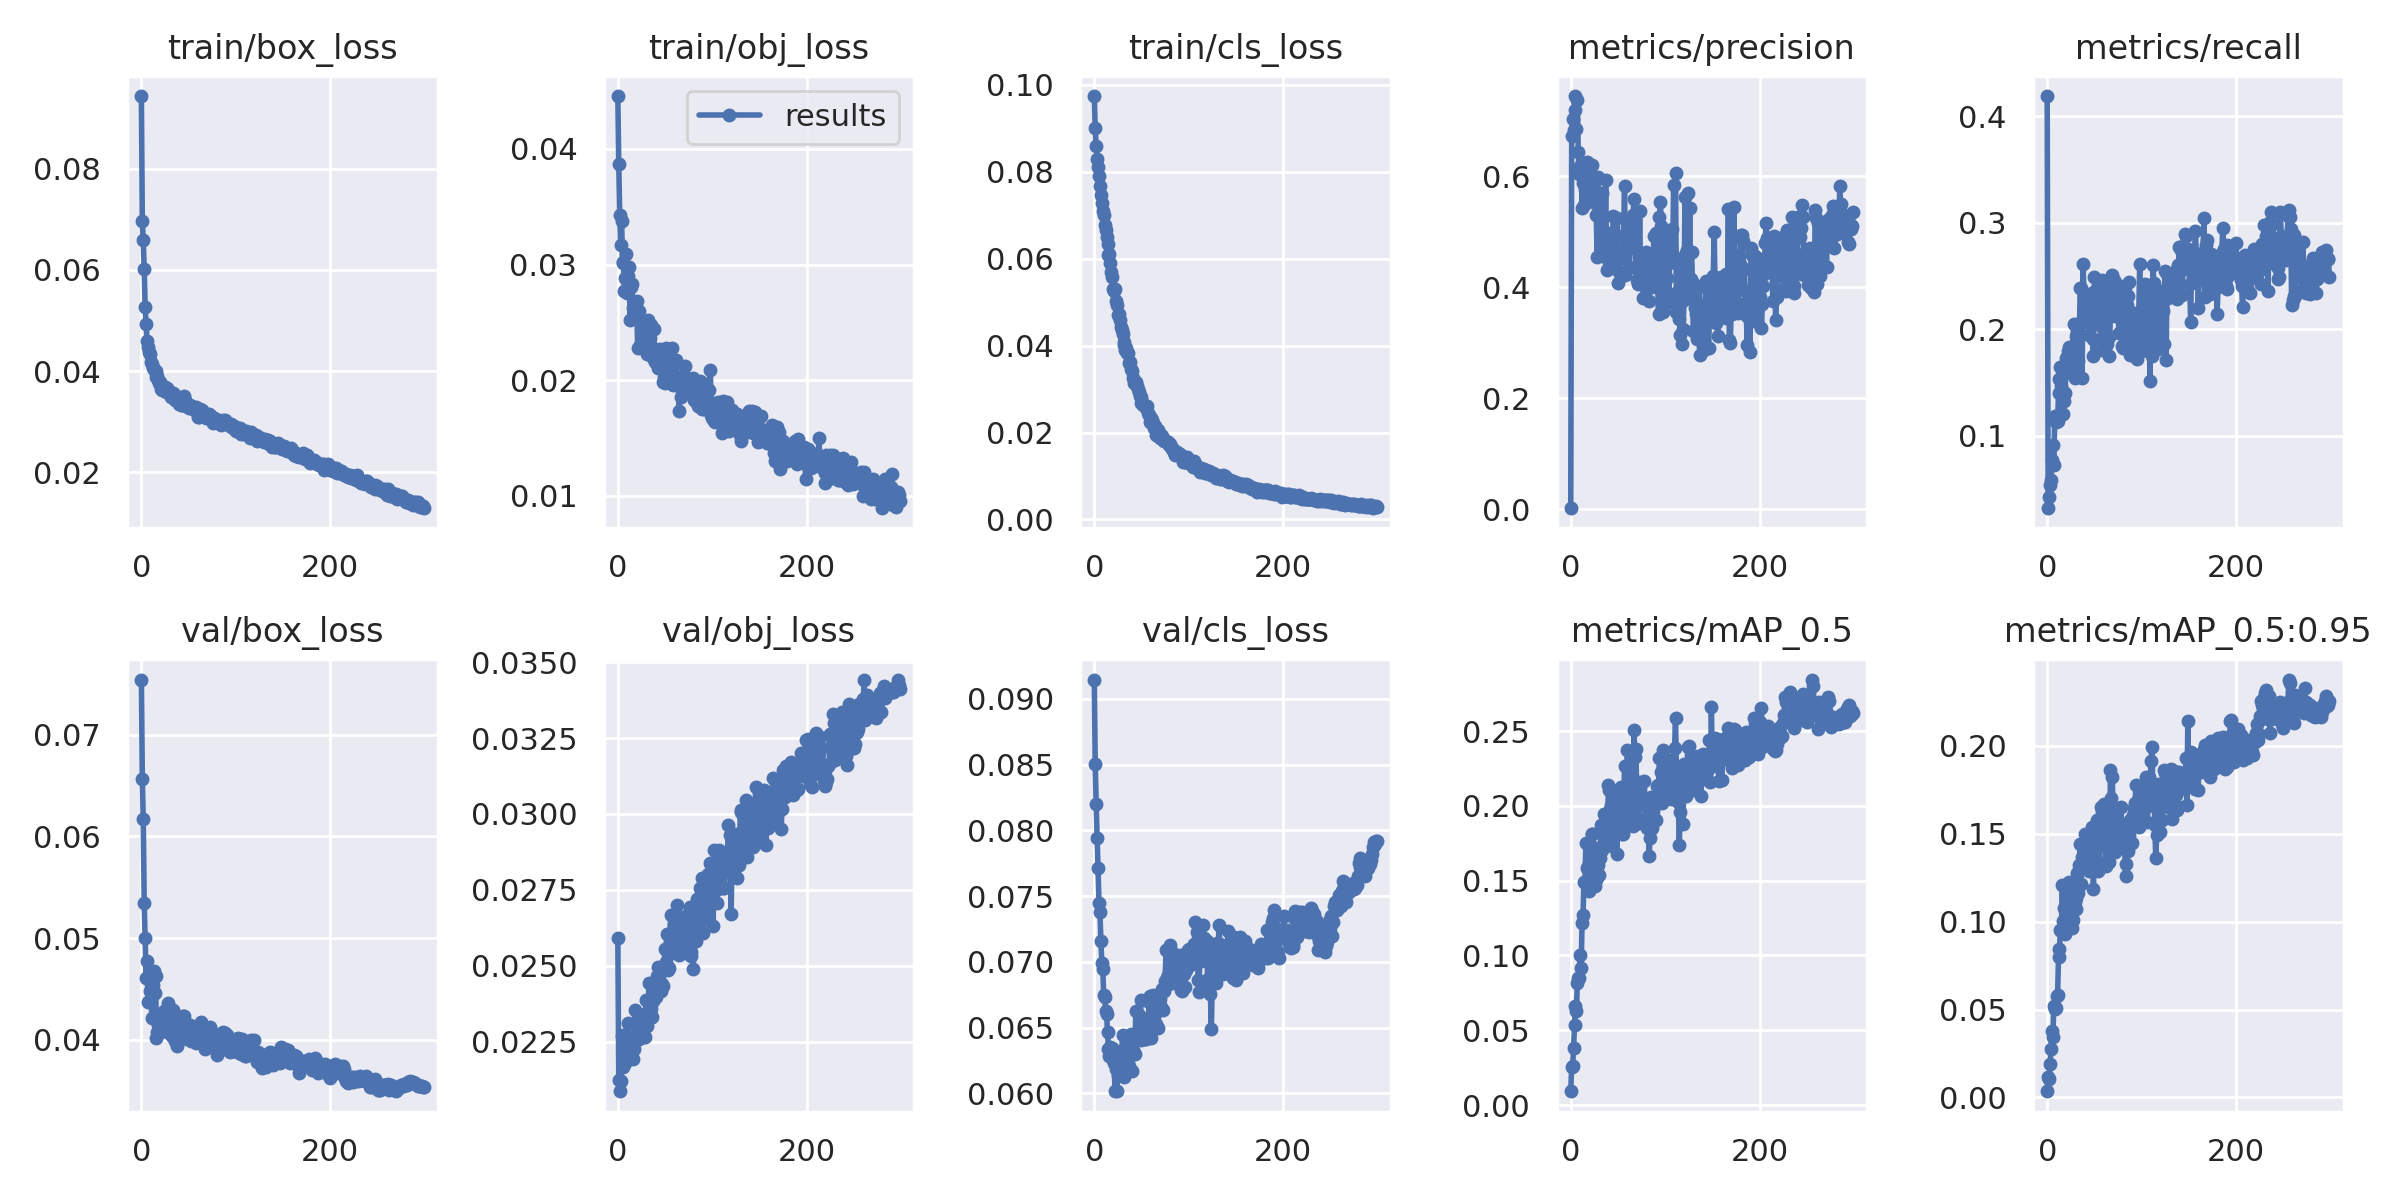

In [42]:
from IPython import display
display.Image("./runs/train/exp3/results.png")

In [43]:
!python val.py --data yoloTACO.yaml --weights runs/train/exp3/weights/best.pt

val: data=/content/yolov5/data/yoloTACO.yaml, weights=['runs/train/exp3/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.2-128-ge8a9c5a Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 322 layers, 86570425 parameters, 0 gradients, 205.0 GFLOPs
val: Scanning '/content/yoloTACO/labels/val.cache' images and labels... 300 found, 0 missing, 0 empty, 0 corrupt: 100% 300/300 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 10/10 [00:22<00:00,  2.26s/it]
                   all        300        955      0.415      0.312      0.287      0.239
Speed: 0.2ms pre-process, 19.3ms inference, 2.4ms NMS per image at shape